In [33]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn import ensemble
from sklearn import linear_model
from sklearn.grid_search import GridSearchCV
from sklearn import preprocessing
from sklearn.cross_validation import train_test_split
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
from collections import Counter

rawdata = 'data/listings.csv'

cols = ['price',
        'accommodates',
        'bedrooms',
        'beds',
        'neighbourhood_cleansed',
        'room_type',
        'cancellation_policy',
        'instant_bookable',
        'reviews_per_month',
        'number_of_reviews',
        'availability_30',
        'review_scores_rating'
        ]

# read the file into a dataframe
df = pd.read_csv(rawdata, usecols=cols)

len(df.index)

8290

In [27]:
total_columns = rawdata.columns

In [32]:
total_columns 

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       'notes', 'transit', 'access', 'interaction', 'house_rules',
       'thumbnail_url', 'medium_url', 'picture_url', 'xl_picture_url',
       'host_id', 'host_url', 'host_name', 'host_since', 'host_location',
       'host_about', 'host_response_time', 'host_response_rate',
       'host_acceptance_rate', 'host_is_superhost', 'host_thumbnail_url',
       'host_picture_url', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'street',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'city', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'latitude', 'longitude',
       'is_location_exact', 'property_type', 'room_type', 'accommodates',
       'bathrooms',

In [28]:
len(total_columns)

96

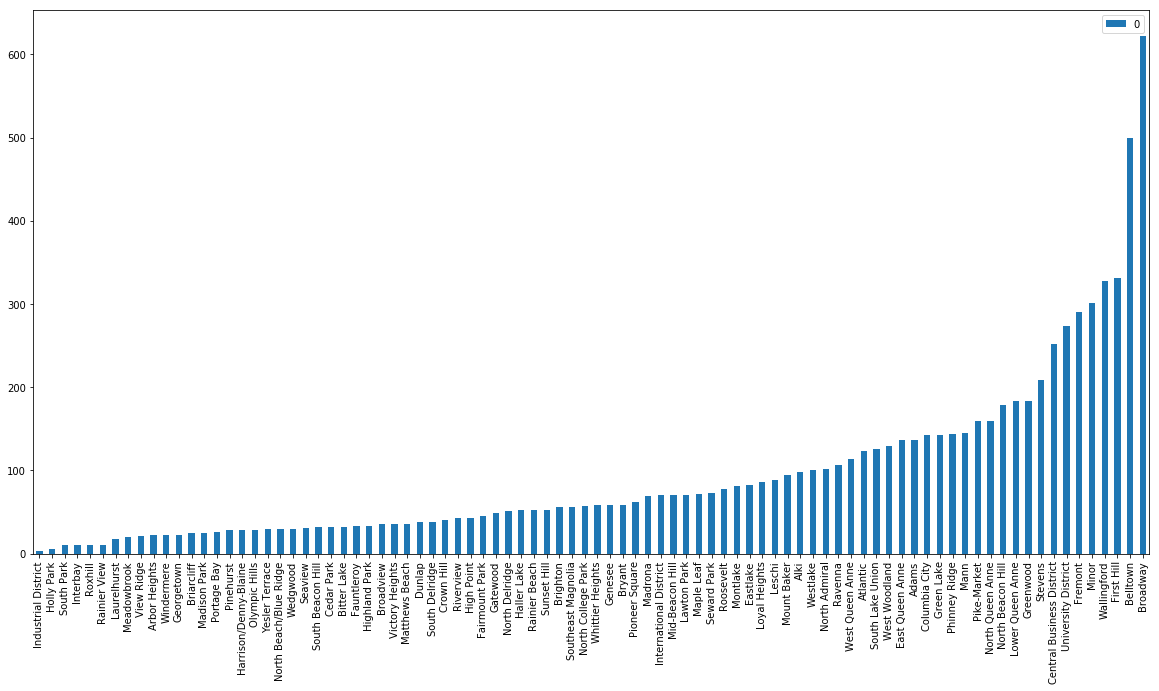

In [2]:
nb_counts = Counter(df.neighbourhood_cleansed)
tdf = pd.DataFrame.from_dict(nb_counts, orient='index').sort_values(by=0)
tdf.plot(kind='bar',figsize=(20, 10))


In [18]:
# the number of entries with 0 'number_of_reviews' which do not a NaN for 'reviews_per_month'
##len(df[(df.number_of_reviews == 0) & (pd.isnull(df.number_of_reviews) == False)
      # & (pd.isnull(df.reviews_per_month) == False)].index)

In [4]:
#fill any NaN 
df['reviews_per_month'].fillna(0, inplace=True)

# drop rows that have zeroes; won't have a huge impact 
df = df[df.bedrooms != 0]
df = df[df.beds != 0]
df = df[df.price != 0]
df = df.dropna(axis=0)

len(df.index)

6315

In [5]:
df = df[df.bedrooms == 1]
len(df.index)

4127

In [6]:
# remove the $ from the price and convert to float
df['price'] = df['price'].replace('[\$,)]','',  \
        regex=True).replace('[(]','-', regex=True).astype(float)
df.price.head(5)

1     82.0
3     90.0
4     70.0
5     80.0
8    120.0
Name: price, dtype: float64

In [7]:
# get dummies 
n_dummies = pd.get_dummies(df.neighbourhood_cleansed)
rt_dummies = pd.get_dummies(df.room_type)
xcl_dummies = pd.get_dummies(df.cancellation_policy)

# make into boolean values for instant bookable 
ib_dummies = pd.get_dummies(df.instant_bookable, prefix="instant")
ib_dummies = ib_dummies.drop('instant_f', axis=1)

# input dummies and drop original columns
alldata = pd.concat((df.drop(['neighbourhood_cleansed', \
    'room_type', 'cancellation_policy', 'instant_bookable'], axis=1), \
    n_dummies.astype(int), rt_dummies.astype(int), \
    xcl_dummies.astype(int), ib_dummies.astype(int)), \
    axis=1)
allcols = alldata.columns
alldata.head(5)

,accommodates,bedrooms,beds,price,availability_30,number_of_reviews,review_scores_rating,reviews_per_month,Adams,Alki,...,Entire home/apt,Private room,Shared room,flexible,moderate,strict,strict_14_with_grace_period,super_strict_30,super_strict_60,instant_t
1,2,1.0,1,82.0,7,54,91.0,0.88,0,0,...,0,1,0,0,1,0,0,0,0,0
3,2,1.0,1,90.0,7,122,91.0,1.11,0,0,...,1,0,0,0,0,0,1,0,0,0
4,2,1.0,1,70.0,0,122,92.0,1.26,0,0,...,0,1,0,0,1,0,0,0,0,0
5,2,1.0,1,80.0,4,377,98.0,3.49,0,0,...,1,0,0,0,1,0,0,0,0,1
8,4,1.0,6,120.0,9,65,86.0,0.75,0,0,...,1,0,0,0,0,0,1,0,0,0


/Users/swatimakhija/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated. Use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


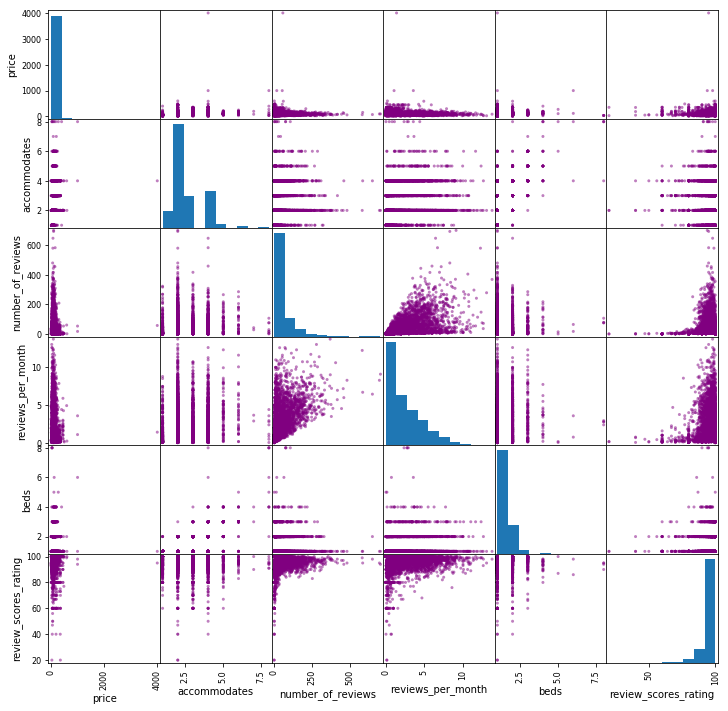

In [34]:
scattercols = ['price','accommodates', 'number_of_reviews', 'reviews_per_month', 'beds', 'review_scores_rating']
axs = pd.scatter_matrix(alldata[scattercols],
                        figsize=(12, 12), c='purple')


Text(0,0.5,'Median Absolute Error')

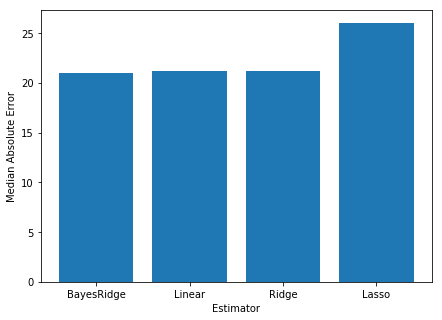

In [9]:
rs  = 1
tests  =  [linear_model.LinearRegression(), linear_model.Ridge(),
        linear_model.Lasso(),
        linear_model.BayesianRidge()]
test_labels = np.array(['Linear', 'Ridge', 'Lasso', 'BayesRidge'])
error_values = np.array([])

X_train, X_test, y_train, y_test = train_test_split(alldata.drop(['price'], axis=1),
                                                    alldata.price, test_size=0.2, random_state=20)

for t in tests:
    t.fit(X_train, y_train)
    this_error = metrics.median_absolute_error(y_test, t.predict(X_test))
    #print "got error %0.2f" % this_err
    error_values = np.append(error_values, this_error)

pos = np.arange(error_values.shape[0])
srt = np.argsort(error_values)
plt.figure(figsize=(7,5))
plt.bar(pos, error_values[srt], align='center')
plt.xticks(pos, test_labels[srt])
plt.xlabel('Estimator')
plt.ylabel('Median Absolute Error')

In [12]:
n_test = 300

tuned_parameters = {
    "n_estimators": [ n_test ],
    "max_depth" : [ 4 ],
    "learning_rate": [ 0.01 ],
    "min_samples_split" : [ 1.0 ],
    "loss" : [ 'ls', 'lad' ]
}

gradient_boosting_regressor = ensemble.GradientBoostingRegressor()
clf = GridSearchCV(gradient_boosting_regressor, cv=3, param_grid=tuned_parameters,
        scoring='median_absolute_error')
predict = clf.fit(X_train, y_train)
best = clf.best_estimator_
best

/Users/swatimakhija/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/swatimakhija/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/swatimakhija/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will be removed in 0.20.
  sample_weight=sample_weight)
/Users/swatimakhija/anaconda3/lib/python3.6/site-packages/sklearn/metrics/scorer.py:100: DeprecationWarning: Scoring method median_absolute_error was renamed to neg_median_absolute_error in version 0.18 and will

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.01, loss='lad', max_depth=4,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=1.0,
             min_weight_fraction_leaf=0.0, n_estimators=300,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [13]:
abs(clf.best_score_)


20.508861777180588

Text(0,0.5,'Least Absolute Deviation')

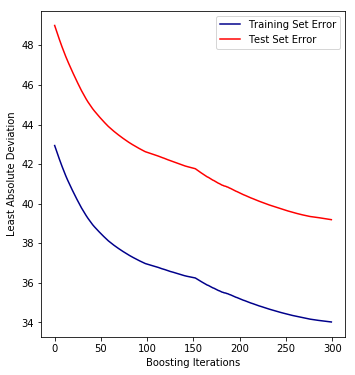

In [14]:

# plot error for each round of boosting# plot er 
test_score = np.zeros(n_test, dtype=np.float64)

train_score = best.train_score_
for i, y_pred in enumerate(best.staged_predict(X_test)):
    test_score[i] = best.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(np.arange(n_test), train_score, 'darkblue', label='Training Set Error')
plt.plot(np.arange(n_test), test_score, 'red', label='Test Set Error')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Least Absolute Deviation')



Text(0.5,1,'Variable Importance')

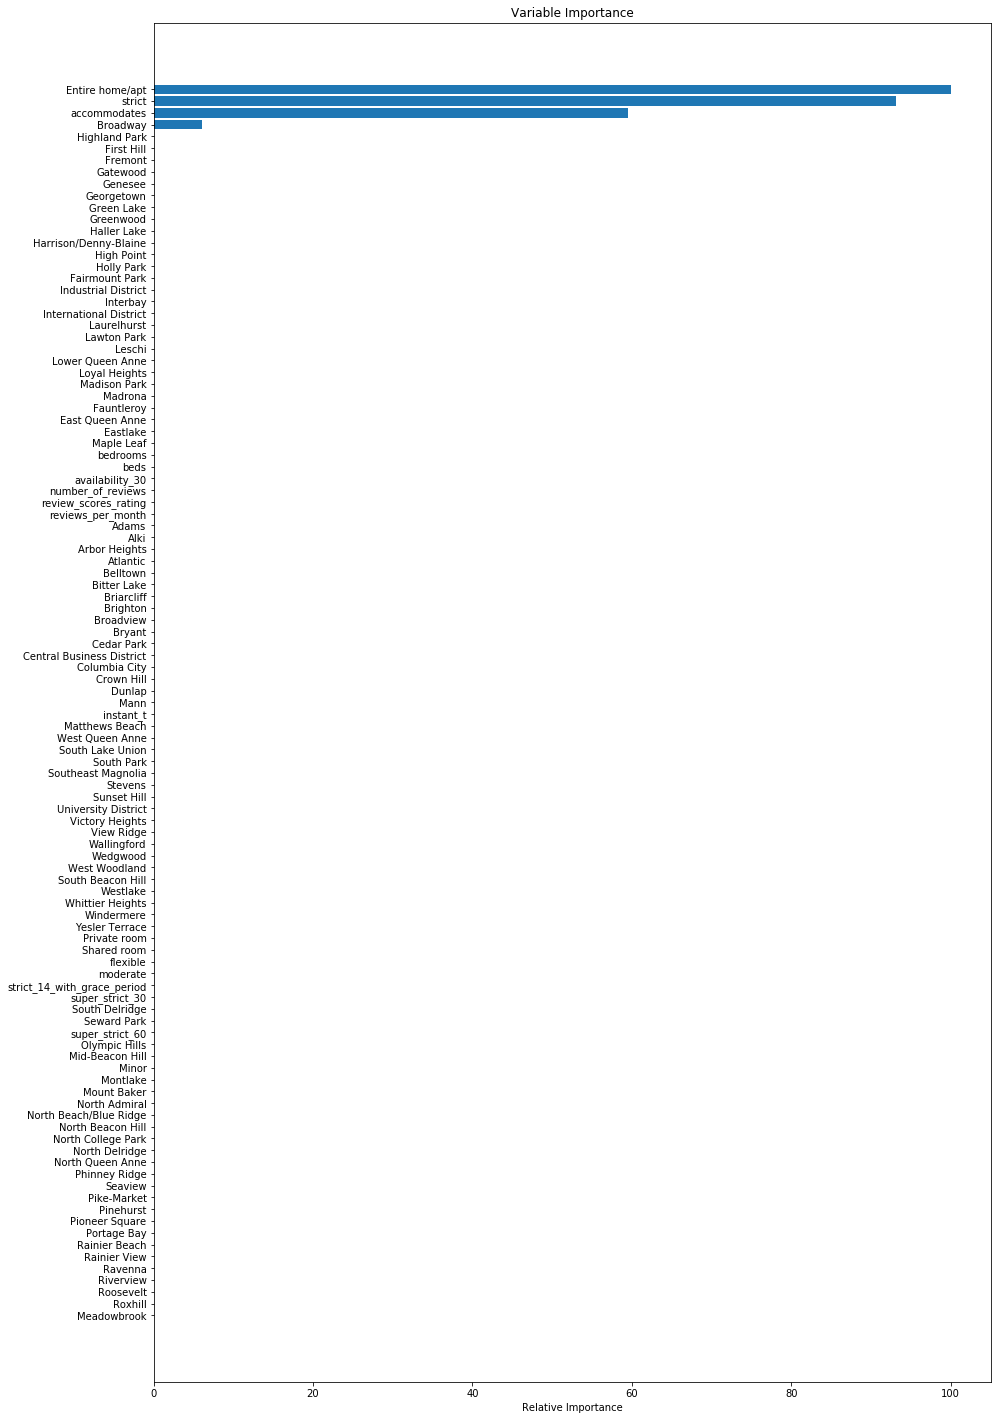

In [15]:
feature_importance = clf.best_estimator_.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
pvals = feature_importance[sorted_idx]
pcols = X_train.columns[sorted_idx]
plt.figure(figsize=(15,25))
plt.barh(pos, pvals, align='center')
plt.yticks(pos, pcols)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')

In [16]:
# TODO: Minimum price of the data
minimum_price = np.min(df['price'])
# Alternative using pandas
# minimum_price = prices.min()

# TODO: Maximum price of the data
maximum_price = np.max(df['price'])
# Alternative using pandas
# maximum_price = prices.max()

# TODO: Mean price of the data
mean_price = np.mean(df['price'])
# Alternative using pandas
# mean_price = prices.mean()

# TODO: Median price of the data
median_price = np.median(df['price'])
# Alternative using pandas
# median_price = prices.median()

# TODO: Standard deviation of prices of the data
std_price = np.std(df['price'])
# Alternative using pandas 
# std_price = prices.std(ddof=0)

# There are other statistics you can calculate too like quartiles
first_quartile = np.percentile(df['price'], 25)
third_quartile = np.percentile(df['price'], 75)
inter_quartile = third_quartile - first_quartile

# Show the calculated statistics
print ("Statistics for Boston housing dataset:\n")
print ("Minimum price: ${:,.2f}".format(minimum_price))
print ("Maximum price: ${:,.2f}".format(maximum_price))
print ("Mean price: ${:,.2f}".format(mean_price))
print ("Median price ${:,.2f}".format(median_price))
print ("Standard deviation of prices: ${:,.2f}".format(std_price))
print ("First quartile of prices: ${:,.2f}".format(first_quartile))
print ("Second quartile of prices: ${:,.2f}".format(third_quartile))
print ("Interquartile (IQR) of prices: ${:,.2f}".format(inter_quartile))

Statistics for Boston housing dataset:

Minimum price: $0.00
Maximum price: $3,999.00
Mean price: $108.02
Median price $91.00
Standard deviation of prices: $90.67
First quartile of prices: $65.00
Second quartile of prices: $129.00
Interquartile (IQR) of prices: $64.00
